# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Process Analysis`*

---
*@author: Evan*\
*@date: 2023-05-09*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
import ModelEvaLib as me

## 读取数据

In [2]:
pa=xr.open_dataset('F:/Data/case_anqing/April/April_PA1.nc')
pa

<xarray.Dataset>
Dimensions:    (time: 720, level: 38, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01 ... 2023-04-30T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 135.8 101.5 72.89
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    HADV_O3    (time, level, y, x) float32 ...
    ZADV_O3    (time, level, y, x) float32 ...
    HDIF_O3    (time, level, y, x) float32 ...
    VDIF_O3    (time, level, y, x) float32 ...
    DDEP_O3    (time, level, y, x) float32 ...
    CHEM_O3    (time, level, y, x) float32 ...
    HNO3prod   (time, level, y, x) float32 ...
    H2O2prod   (time, level, y, x) float32 ...
    O3prod     (time, level, y, x) float32 ...
    O3loss     (time, level, y, x) float32 ...
Attributes:
    case:     Anqing_202304
    grid:     CN3AH_135X138

In [3]:
HADV = pa.HADV_O3
ZADV = pa.ZADV_O3
HDIF = pa.HDIF_O3
VDIF = pa.VDIF_O3
DDEP = pa.DDEP_O3
CHEM = pa.CHEM_O3

In [4]:
import geopandas as gpd
shpurban = 'F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp'
shp = gpd.read_file(shpurban)
for i in range(np.size(pa.latitude,0)):
    for j in range(np.size(pa.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],pa.longitude[i,j],pa.latitude[i,j])==False:
            HADV[:,:,i,j] = np.nan
            ZADV[:,:,i,j] = np.nan
            HDIF[:,:,i,j] = np.nan
            VDIF[:,:,i,j] = np.nan
            DDEP[:,:,i,j] = np.nan
            CHEM[:,:,i,j] = np.nan
            
hadv = np.nanmean(np.nanmean(HADV,2),2)
zadv = np.nanmean(np.nanmean(ZADV,2),2)
hdif = np.nanmean(np.nanmean(HDIF,2),2)
vdif = np.nanmean(np.nanmean(VDIF,2),2)
ddep = np.nanmean(np.nanmean(DDEP,2),2)
chem = np.nanmean(np.nanmean(CHEM,2),2)

分别提取白天和夜晚数据后求平均，白天：6-18h

In [5]:
day_index=np.arange(6,18)
night_index=np.array([0,1,2,3,4,7,18,19,20,21,22,23])
days=[]
nights=[]
for i in range(30):
    days=np.append(days,day_index+24*i)
    nights=np.append(nights,night_index+24*i)

print(days.shape, nights.shape)

(360,) (360,)


In [9]:
# 定义数组名称列表
arrays = ['hadv', 'zadv', 'hdif', 'vdif', 'ddep', 'chem']
nlevel=28

#! 使用循环将各个数组的日夜分离、正负分离
for array in arrays:
    # 根据数组名称获得对应的数组
    current_array = locals()[array][:,:nlevel]
    # 创建新的数组名称并将其添加到局部变量中
    for time_of_day in ['day', 'night']:
        new_array_name = f"{array}_{time_of_day}"
        locals()[new_array_name] = np.mean(current_array[days.astype(int) if time_of_day == 'day' else nights.astype(int), :].reshape(30, 12, nlevel),1)

        for m in np.arange(1,4):
            mname = f"{new_array_name}_m{m}"
            locals()[mname] = np.mean(locals()[new_array_name][(m-1)*10:m*10,:],0)

            pos_name = f"{mname}_pos"
            locals()[pos_name] = np.maximum(0, locals()[mname])
            neg_name = f"{mname}_neg"
            locals()[neg_name] = np.minimum(0, locals()[mname])

hadv_day_m1_pos.shape

(28,)

## 绘图

## 分时间段画图

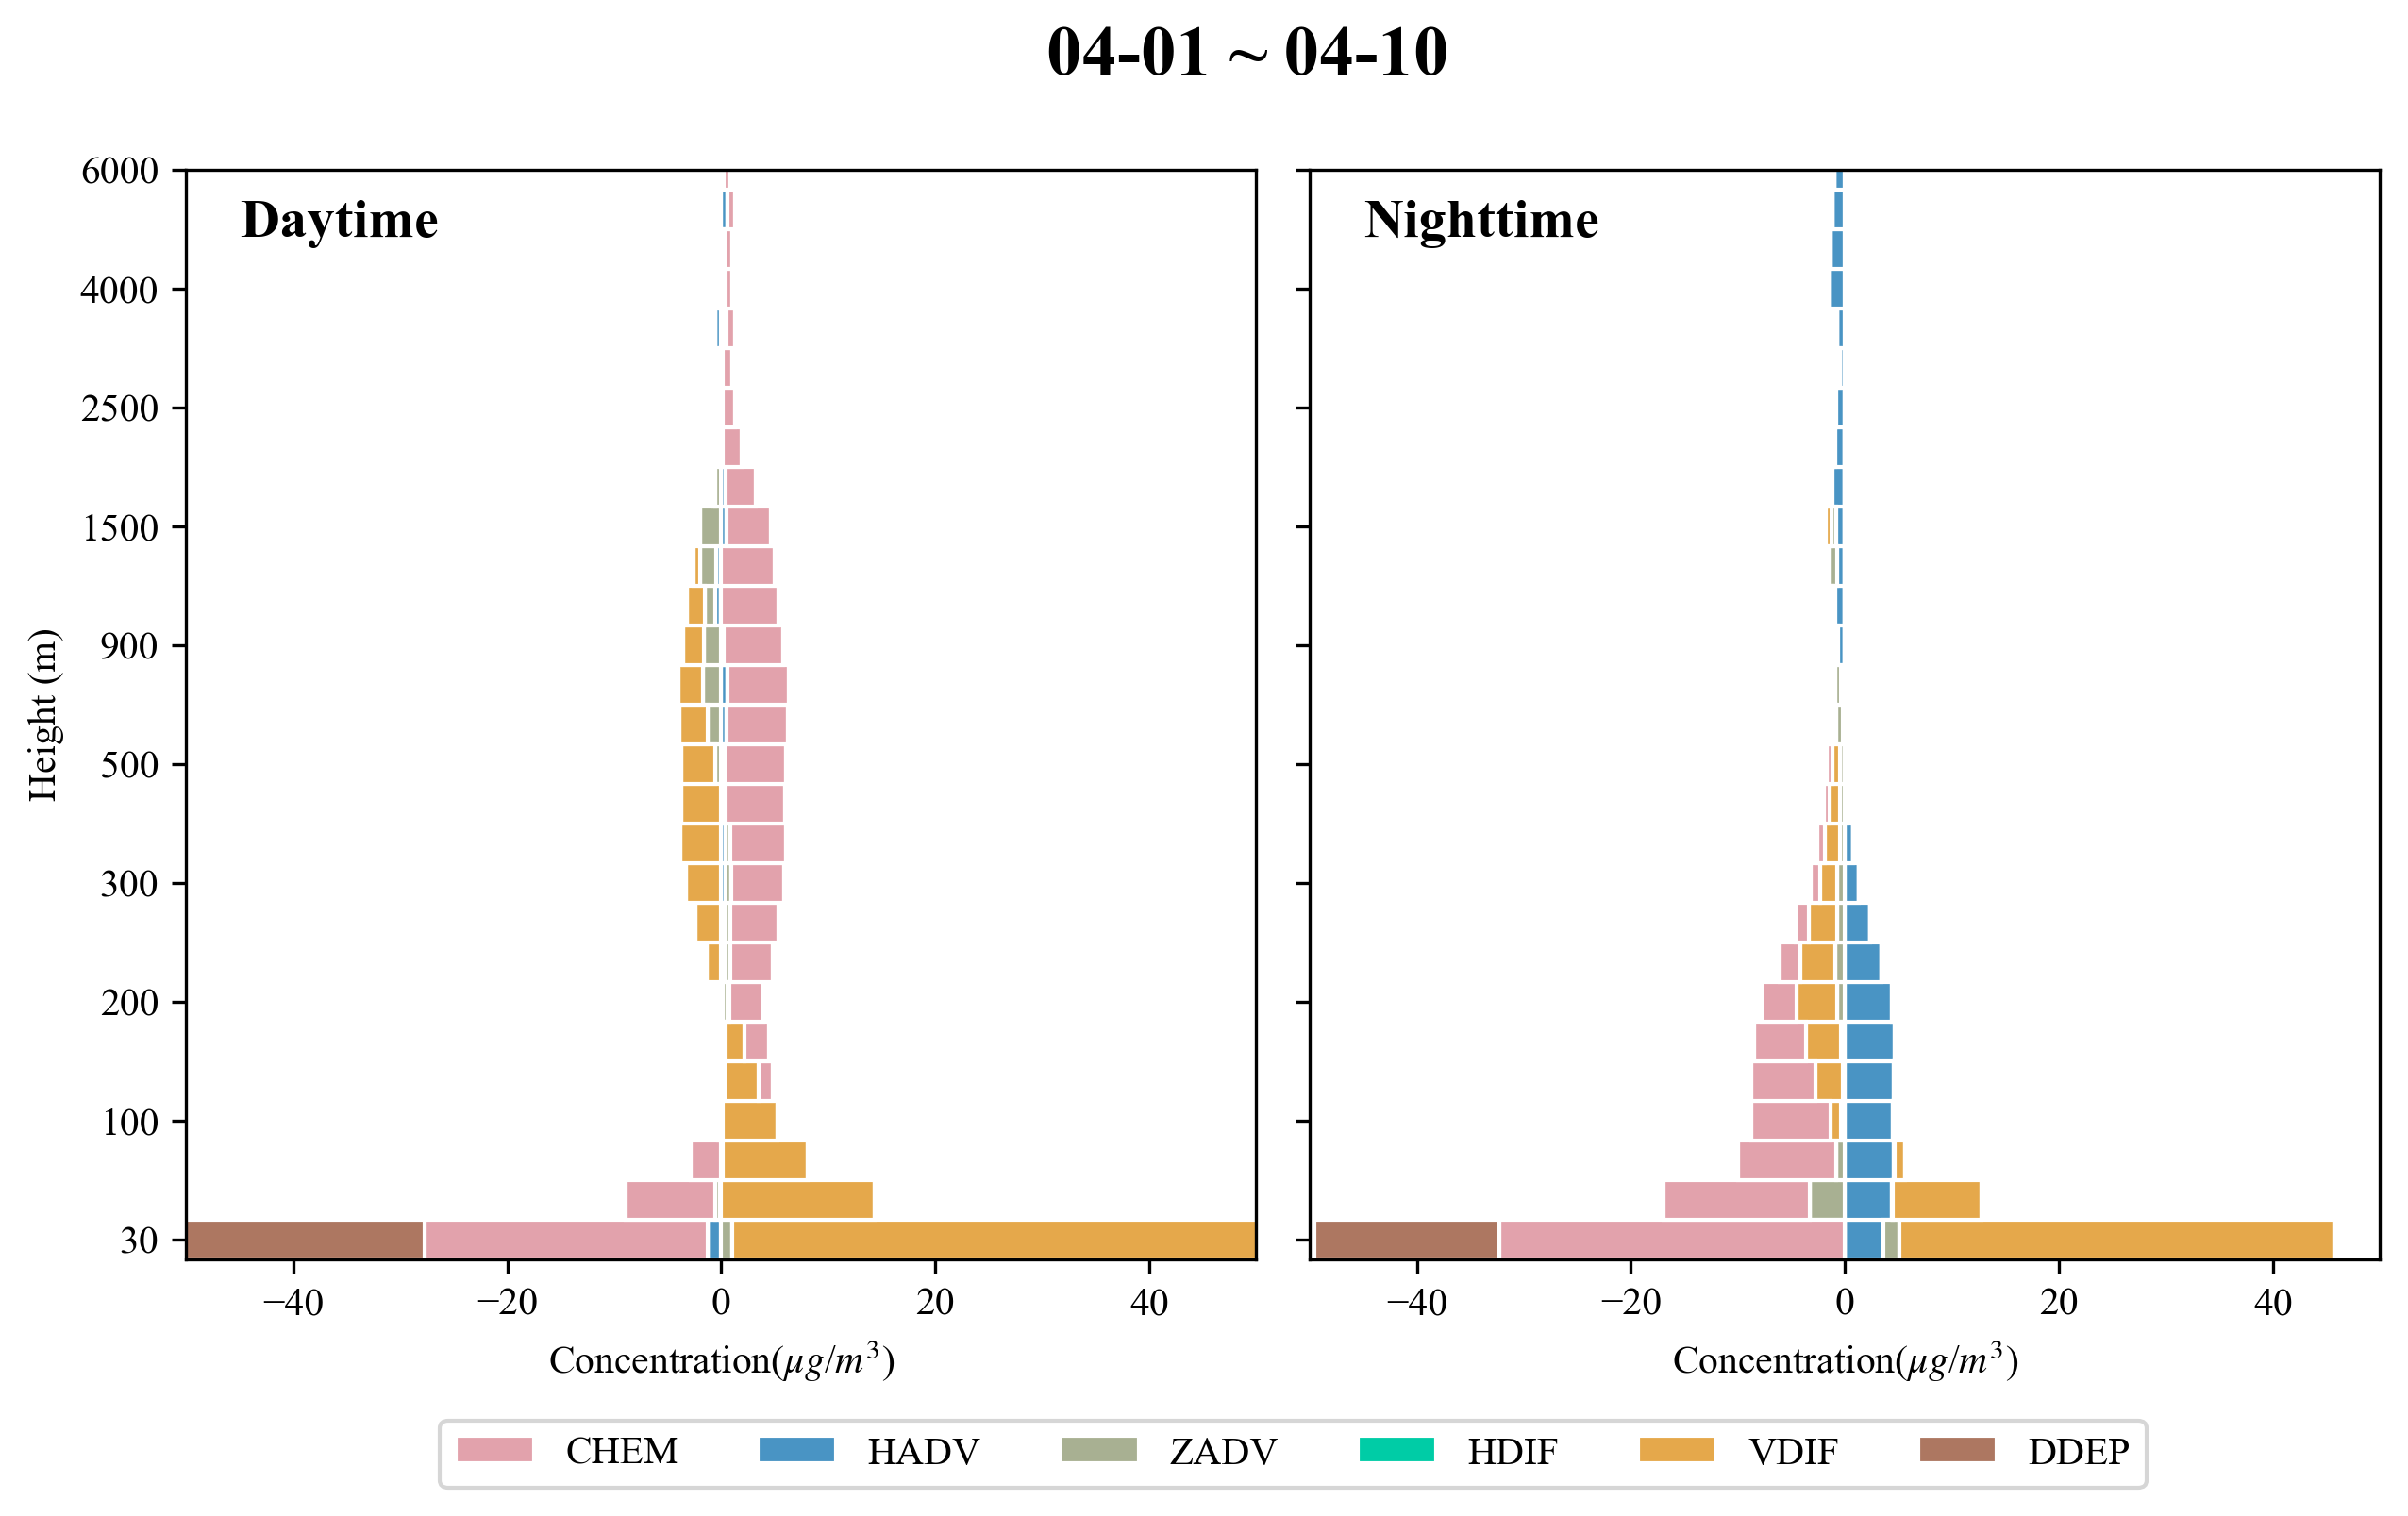

In [11]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,hadv_day_m1_pos,color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,hadv_day_m1_neg,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,zadv_day_m1_pos,color=color_zadv,left=hadv_day_m1_pos,height=1,edgecolor=edgec)
ax[0].barh(h,zadv_day_m1_neg,color=color_zadv,left=hadv_day_m1_neg,height=1,edgecolor=edgec)

b3=ax[0].barh(h,hdif_day_m1_pos,color=color_hdif,left=hadv_day_m1_pos+zadv_day_m1_pos,height=1,edgecolor=edgec)
ax[0].barh(h,hdif_day_m1_neg,color=color_hdif,left=hadv_day_m1_neg+zadv_day_m1_neg,height=1,edgecolor=edgec)

b4=ax[0].barh(h,vdif_day_m1_pos,color=color_vdif,left=hadv_day_m1_pos+zadv_day_m1_pos+hdif_day_m1_pos,height=1,edgecolor=edgec)
ax[0].barh(h,vdif_day_m1_neg,color=color_vdif,left=hadv_day_m1_neg+zadv_day_m1_neg+hdif_day_m1_neg,height=1,edgecolor=edgec)

b5=ax[0].barh(h,chem_day_m1_pos,color=color_chem,left=hadv_day_m1_pos+zadv_day_m1_pos+vdif_day_m1_pos+hdif_day_m1_pos,
            height=1,edgecolor=edgec)
ax[0].barh(h,chem_day_m1_neg,color=color_chem,left=hadv_day_m1_neg+zadv_day_m1_neg+vdif_day_m1_neg+hdif_day_m1_neg,
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,ddep_day_m1_pos,color=color_ddep,left=hadv_day_m1_pos+zadv_day_m1_pos+vdif_day_m1_pos+hdif_day_m1_pos+chem_day_m1_pos,
            height=1,edgecolor=edgec)
ax[0].barh(h,ddep_day_m1_neg,color=color_ddep,left=hadv_day_m1_neg+zadv_day_m1_neg+vdif_day_m1_neg+hdif_day_m1_neg+chem_day_m1_neg,
            height=1,edgecolor=edgec)

ax[0].set_xlim(-50,50)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-80,81,20))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,hadv_night_m1_pos,color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,hadv_night_m1_neg,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,zadv_night_m1_pos,color=color_zadv,left=hadv_night_m1_pos,height=1,edgecolor=edgec)
ax[1].barh(h,zadv_night_m1_neg,color=color_zadv,left=hadv_night_m1_neg,height=1,edgecolor=edgec)

b3=ax[1].barh(h,hdif_night_m1_pos,color=color_hdif,left=hadv_night_m1_pos+zadv_night_m1_pos,height=1,edgecolor=edgec)
ax[1].barh(h,hdif_night_m1_neg,color=color_hdif,left=hadv_night_m1_neg+zadv_night_m1_neg,height=1,edgecolor=edgec)

b4=ax[1].barh(h,vdif_night_m1_pos,color=color_vdif,left=hadv_night_m1_pos+zadv_night_m1_pos+hdif_night_m1_pos,height=1,edgecolor=edgec)
ax[1].barh(h,vdif_night_m1_neg,color=color_vdif,left=hadv_night_m1_neg+zadv_night_m1_neg+hdif_night_m1_neg,height=1,edgecolor=edgec)

b5=ax[1].barh(h,chem_night_m1_pos,color=color_chem,left=hadv_night_m1_pos+zadv_night_m1_pos+vdif_night_m1_pos+hdif_night_m1_pos,
            height=1,edgecolor=edgec)
ax[1].barh(h,chem_night_m1_neg,color=color_chem,left=hadv_night_m1_neg+zadv_night_m1_neg+vdif_night_m1_neg+hdif_night_m1_neg,
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,ddep_night_m1_pos,color=color_ddep,left=hadv_night_m1_pos+zadv_night_m1_pos+vdif_night_m1_pos+hdif_night_m1_pos+chem_night_m1_pos,
            height=1,edgecolor=edgec)
ax[1].barh(h,ddep_night_m1_neg,color=color_ddep,left=hadv_night_m1_neg+zadv_night_m1_neg+vdif_night_m1_neg+hdif_night_m1_neg+chem_night_m1_neg,
            height=1,edgecolor=edgec)

ax[1].set_xlim(-50,50)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle('04-01 ~ 04-10',
             fontsize=18,fontweight='bold')
plt.show()

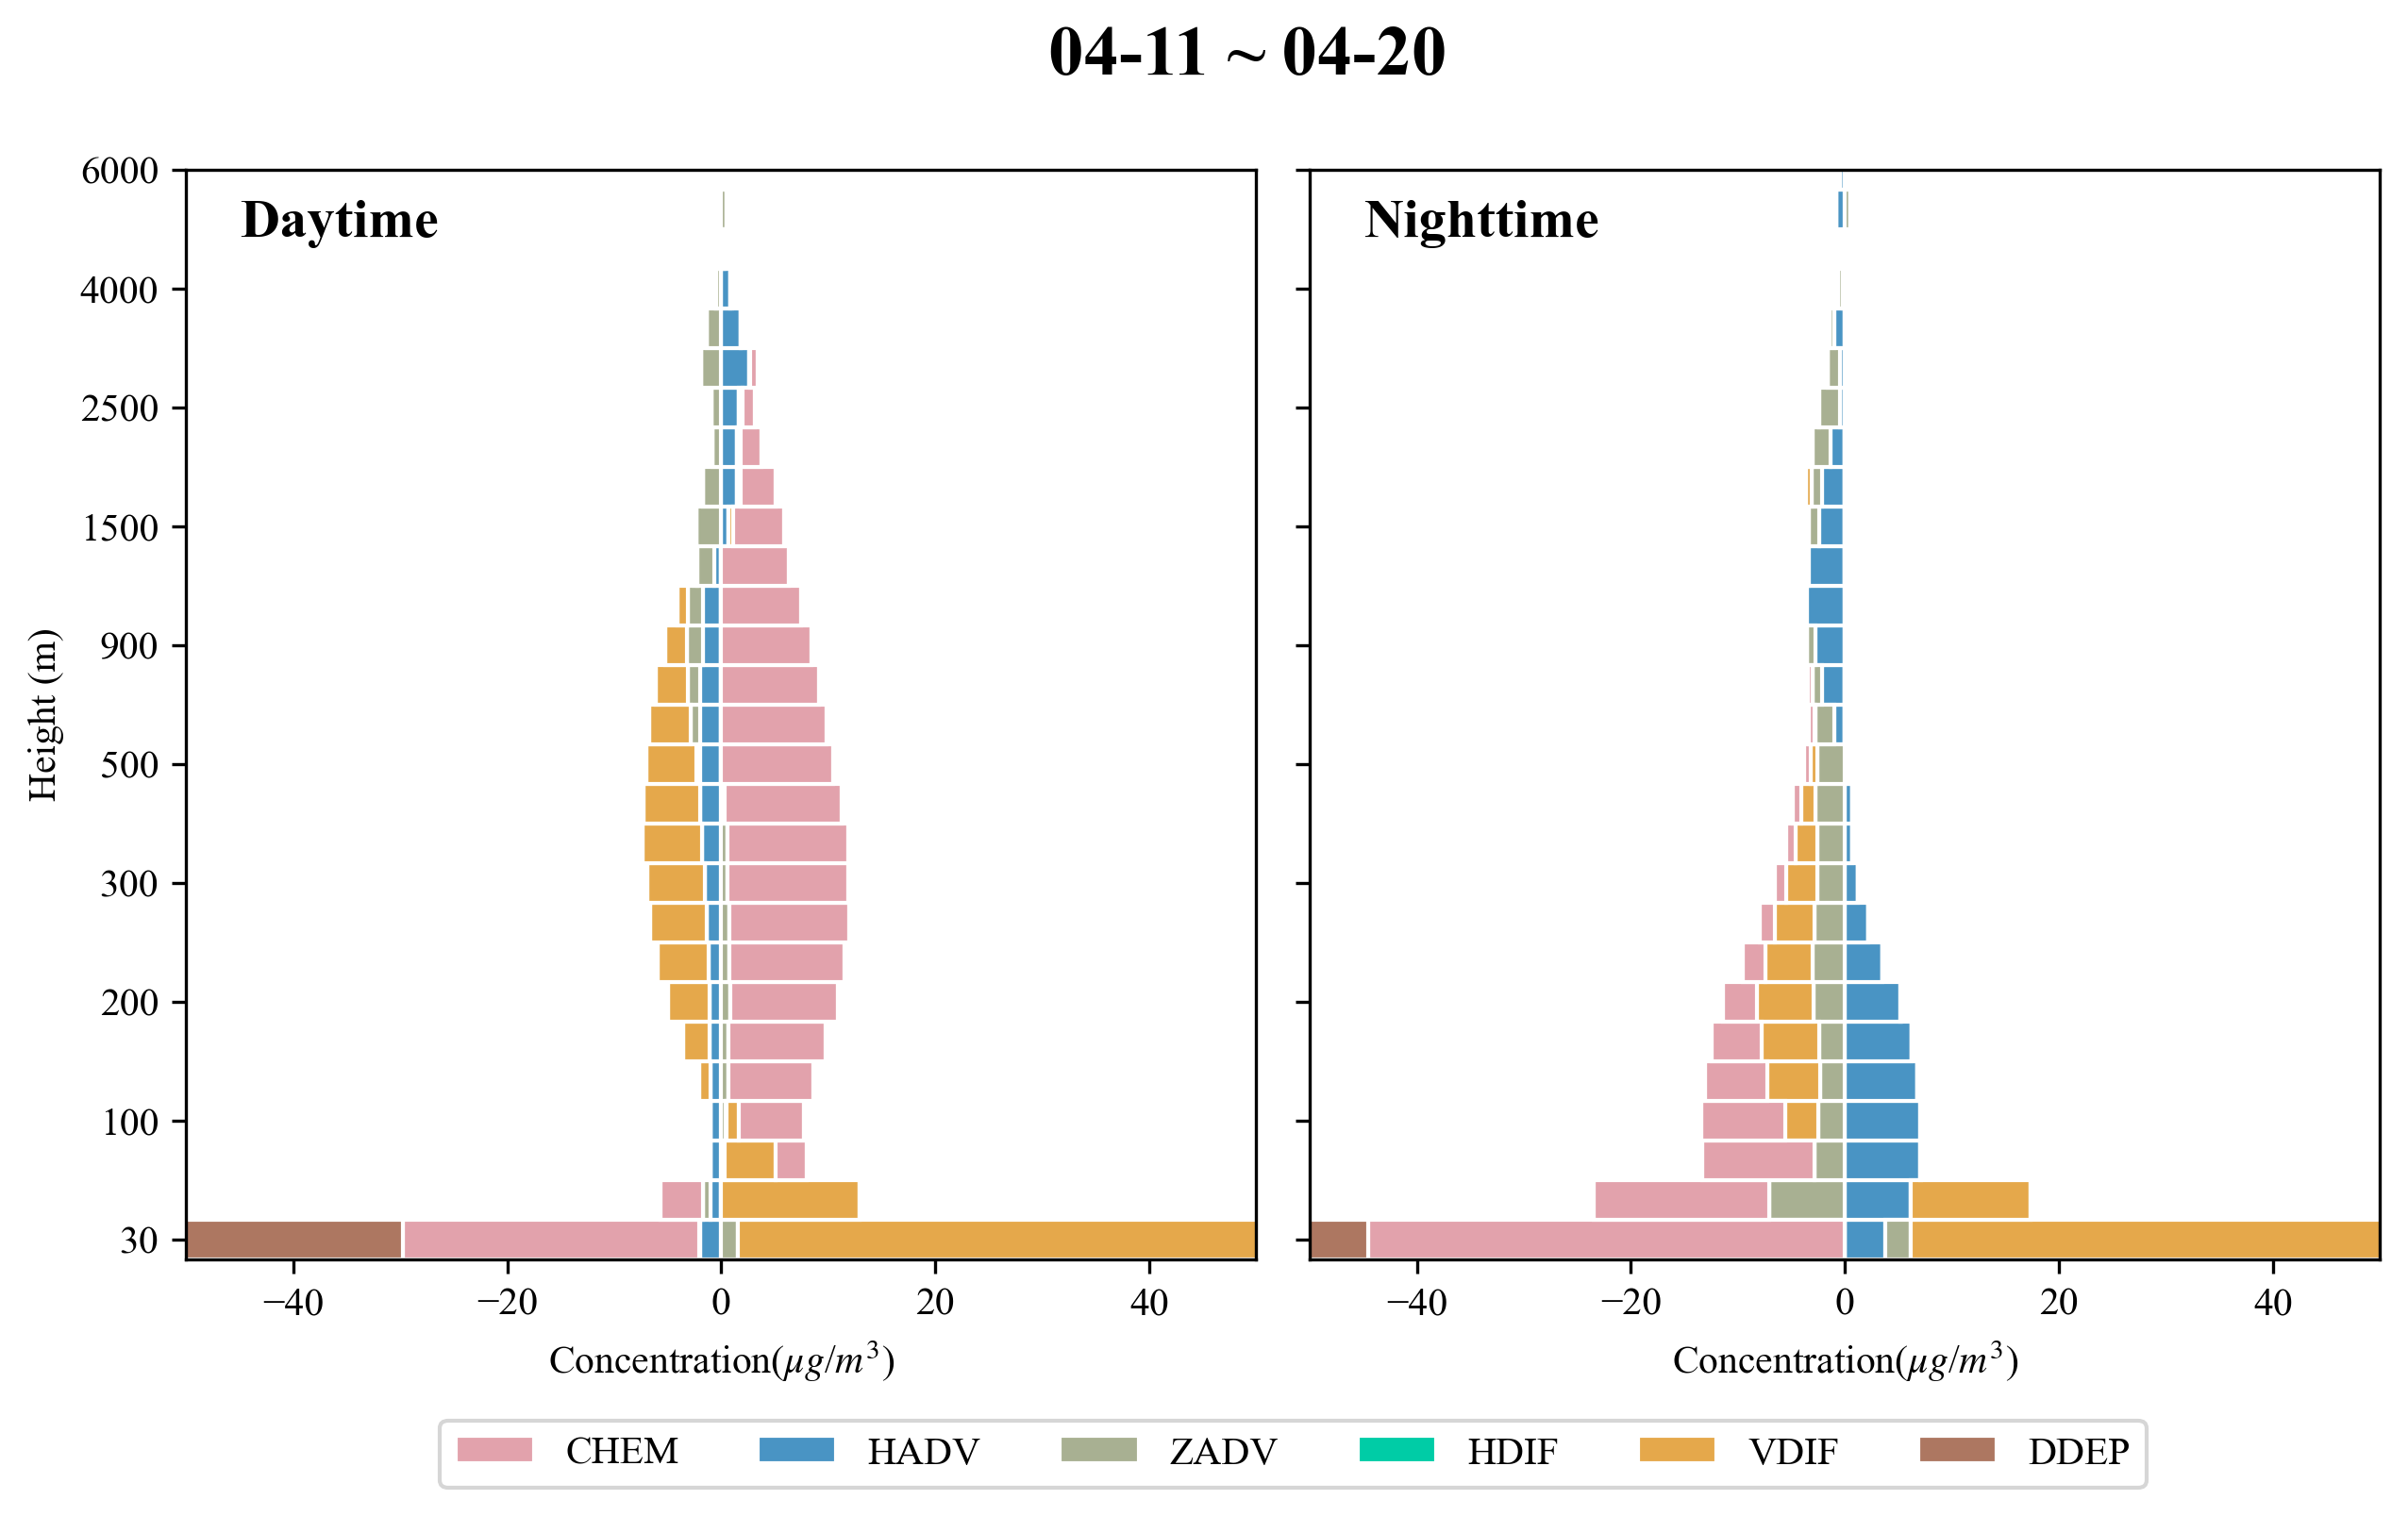

In [12]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,hadv_day_m2_pos,color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,hadv_day_m2_neg,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,zadv_day_m2_pos,color=color_zadv,left=hadv_day_m2_pos,height=1,edgecolor=edgec)
ax[0].barh(h,zadv_day_m2_neg,color=color_zadv,left=hadv_day_m2_neg,height=1,edgecolor=edgec)

b3=ax[0].barh(h,hdif_day_m2_pos,color=color_hdif,left=hadv_day_m2_pos+zadv_day_m2_pos,height=1,edgecolor=edgec)
ax[0].barh(h,hdif_day_m2_neg,color=color_hdif,left=hadv_day_m2_neg+zadv_day_m2_neg,height=1,edgecolor=edgec)

b4=ax[0].barh(h,vdif_day_m2_pos,color=color_vdif,left=hadv_day_m2_pos+zadv_day_m2_pos+hdif_day_m2_pos,height=1,edgecolor=edgec)
ax[0].barh(h,vdif_day_m2_neg,color=color_vdif,left=hadv_day_m2_neg+zadv_day_m2_neg+hdif_day_m2_neg,height=1,edgecolor=edgec)

b5=ax[0].barh(h,chem_day_m2_pos,color=color_chem,left=hadv_day_m2_pos+zadv_day_m2_pos+vdif_day_m2_pos+hdif_day_m2_pos,
            height=1,edgecolor=edgec)
ax[0].barh(h,chem_day_m2_neg,color=color_chem,left=hadv_day_m2_neg+zadv_day_m2_neg+vdif_day_m2_neg+hdif_day_m2_neg,
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,ddep_day_m2_pos,color=color_ddep,left=hadv_day_m2_pos+zadv_day_m2_pos+vdif_day_m2_pos+hdif_day_m2_pos+chem_day_m2_pos,
            height=1,edgecolor=edgec)
ax[0].barh(h,ddep_day_m2_neg,color=color_ddep,left=hadv_day_m2_neg+zadv_day_m2_neg+vdif_day_m2_neg+hdif_day_m2_neg+chem_day_m2_neg,
            height=1,edgecolor=edgec)

ax[0].set_xlim(-50,50)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-80,81,20))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,hadv_night_m2_pos,color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,hadv_night_m2_neg,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,zadv_night_m2_pos,color=color_zadv,left=hadv_night_m2_pos,height=1,edgecolor=edgec)
ax[1].barh(h,zadv_night_m2_neg,color=color_zadv,left=hadv_night_m2_neg,height=1,edgecolor=edgec)

b3=ax[1].barh(h,hdif_night_m2_pos,color=color_hdif,left=hadv_night_m2_pos+zadv_night_m2_pos,height=1,edgecolor=edgec)
ax[1].barh(h,hdif_night_m2_neg,color=color_hdif,left=hadv_night_m2_neg+zadv_night_m2_neg,height=1,edgecolor=edgec)

b4=ax[1].barh(h,vdif_night_m2_pos,color=color_vdif,left=hadv_night_m2_pos+zadv_night_m2_pos+hdif_night_m2_pos,height=1,edgecolor=edgec)
ax[1].barh(h,vdif_night_m2_neg,color=color_vdif,left=hadv_night_m2_neg+zadv_night_m2_neg+hdif_night_m2_neg,height=1,edgecolor=edgec)

b5=ax[1].barh(h,chem_night_m2_pos,color=color_chem,left=hadv_night_m2_pos+zadv_night_m2_pos+vdif_night_m2_pos+hdif_night_m2_pos,
            height=1,edgecolor=edgec)
ax[1].barh(h,chem_night_m2_neg,color=color_chem,left=hadv_night_m2_neg+zadv_night_m2_neg+vdif_night_m2_neg+hdif_night_m2_neg,
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,ddep_night_m2_pos,color=color_ddep,left=hadv_night_m2_pos+zadv_night_m2_pos+vdif_night_m2_pos+hdif_night_m2_pos+chem_night_m2_pos,
            height=1,edgecolor=edgec)
ax[1].barh(h,ddep_night_m2_neg,color=color_ddep,left=hadv_night_m2_neg+zadv_night_m2_neg+vdif_night_m2_neg+hdif_night_m2_neg+chem_night_m2_neg,
            height=1,edgecolor=edgec)

ax[1].set_xlim(-50,50)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle('04-11 ~ 04-20',
             fontsize=18,fontweight='bold')
plt.show()

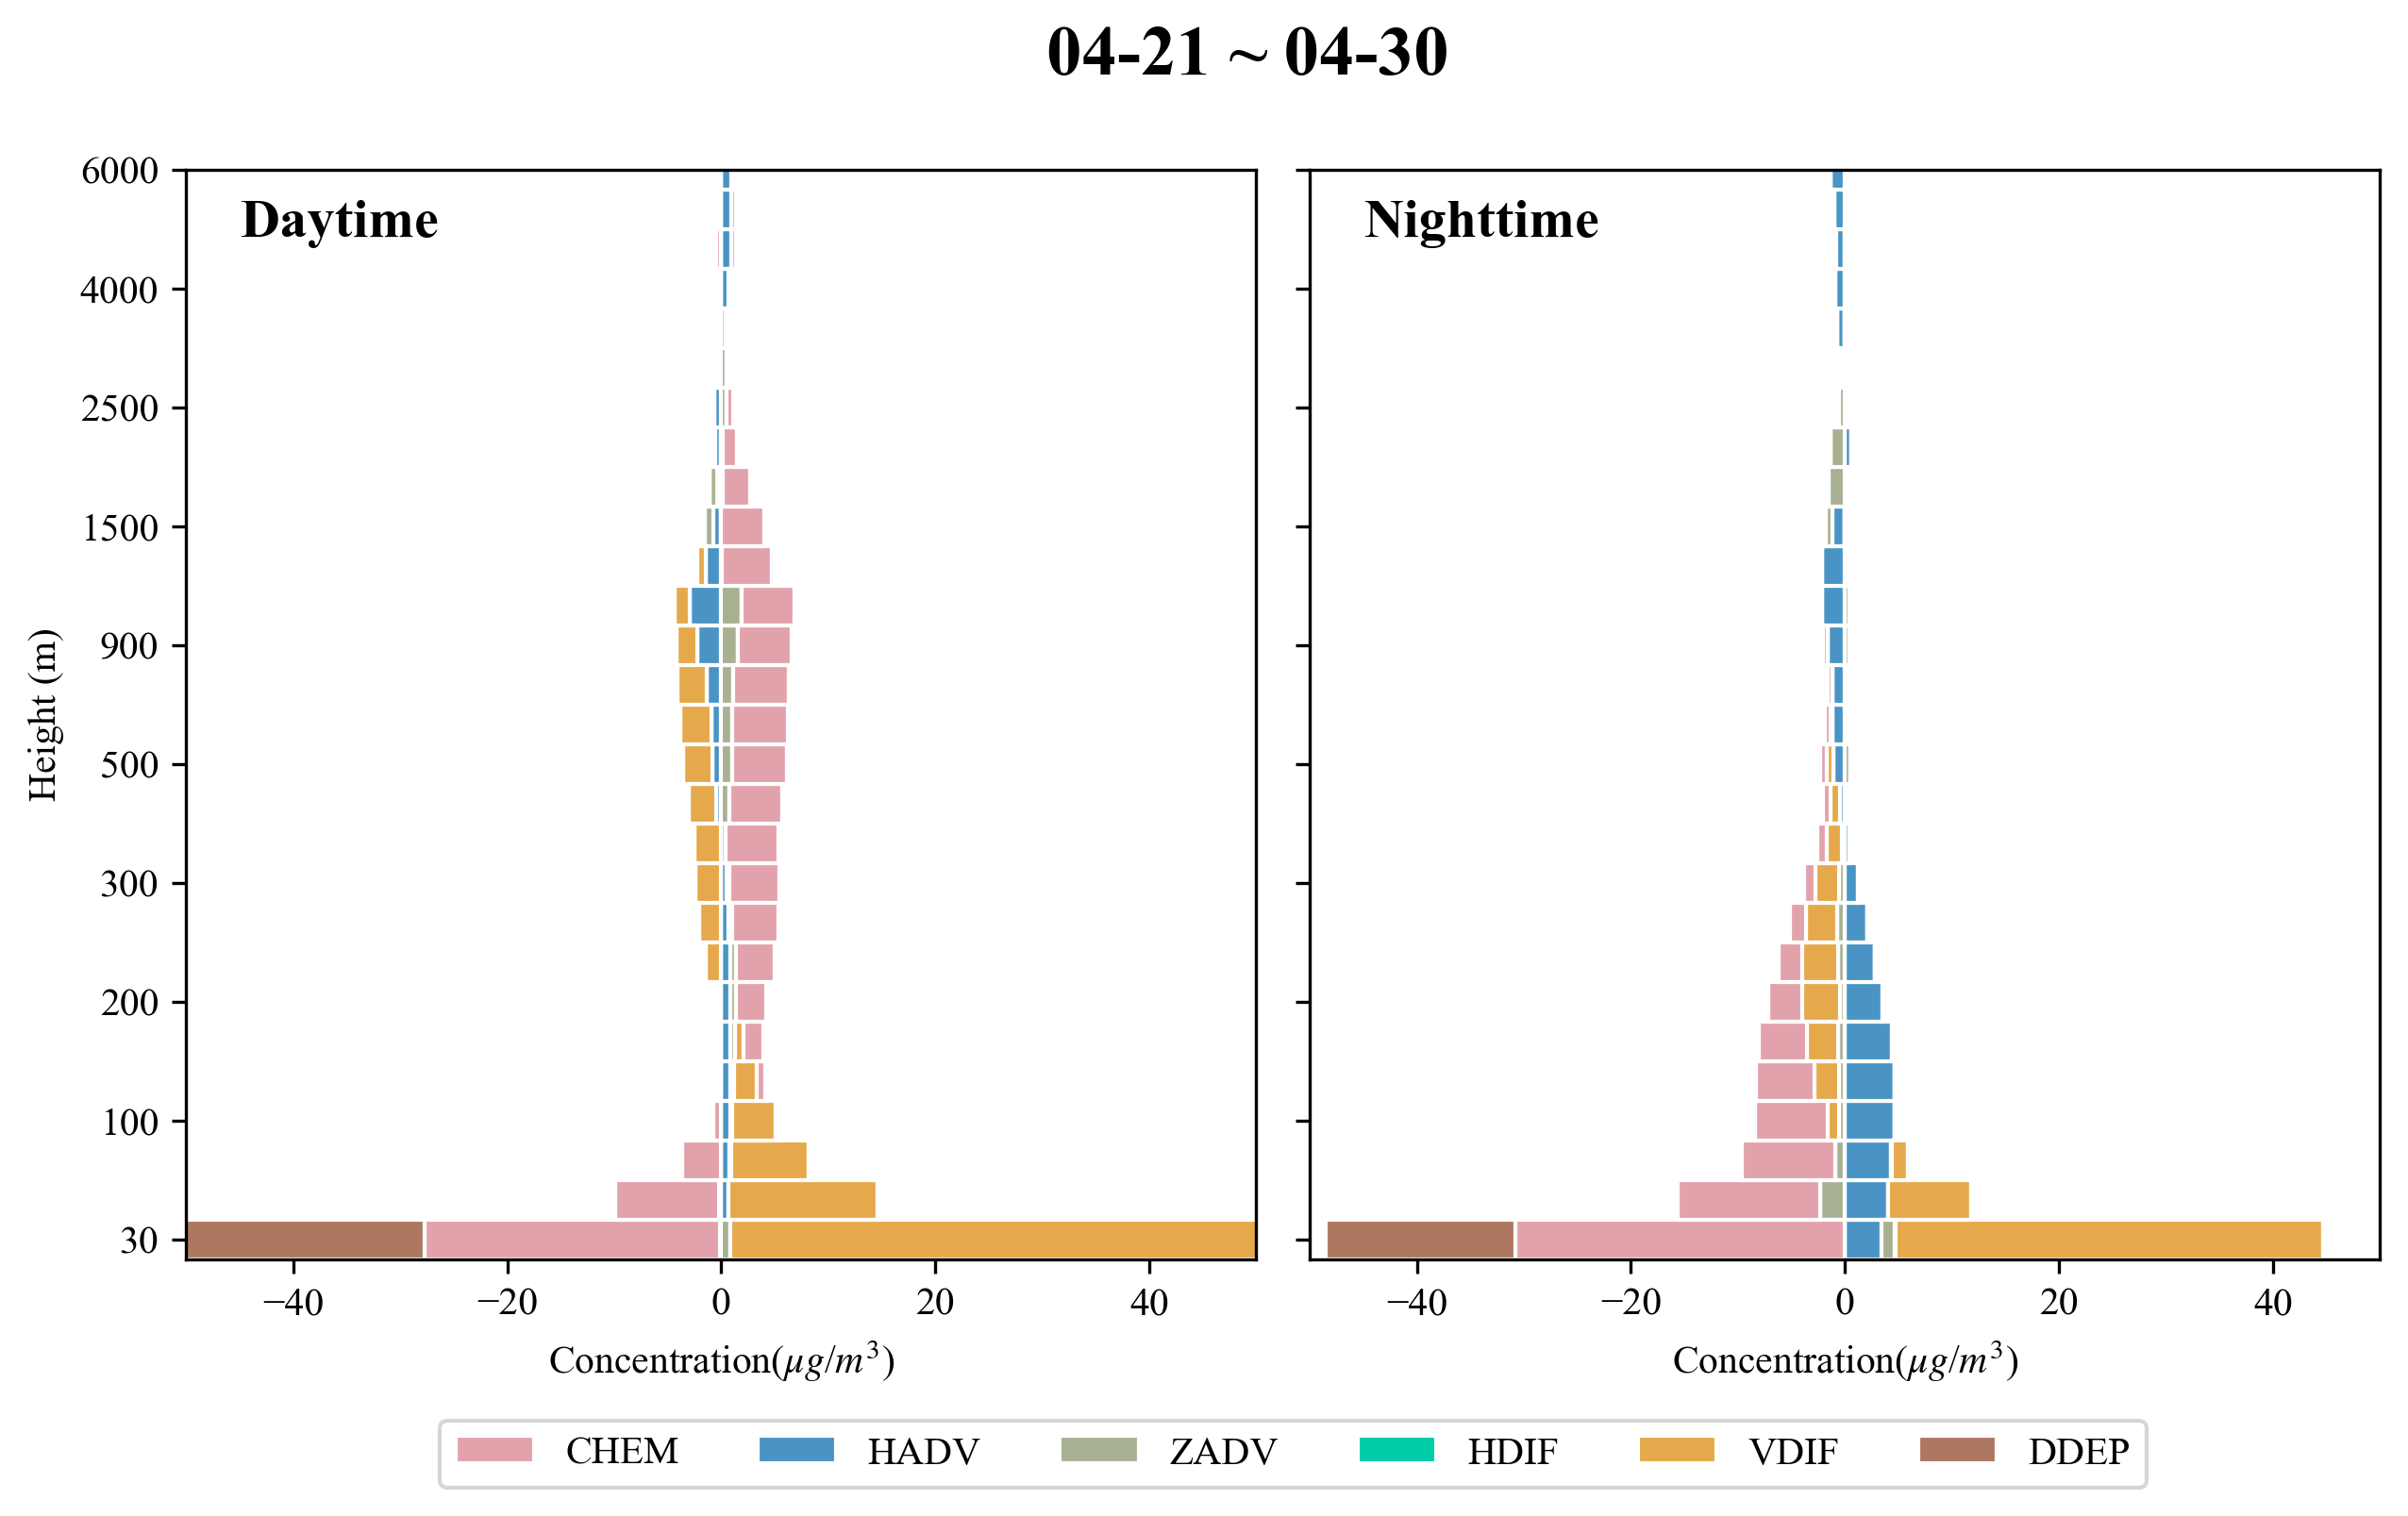

In [13]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,hadv_day_m3_pos,color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,hadv_day_m3_neg,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,zadv_day_m3_pos,color=color_zadv,left=hadv_day_m3_pos,height=1,edgecolor=edgec)
ax[0].barh(h,zadv_day_m3_neg,color=color_zadv,left=hadv_day_m3_neg,height=1,edgecolor=edgec)

b3=ax[0].barh(h,hdif_day_m3_pos,color=color_hdif,left=hadv_day_m3_pos+zadv_day_m3_pos,height=1,edgecolor=edgec)
ax[0].barh(h,hdif_day_m3_neg,color=color_hdif,left=hadv_day_m3_neg+zadv_day_m3_neg,height=1,edgecolor=edgec)

b4=ax[0].barh(h,vdif_day_m3_pos,color=color_vdif,left=hadv_day_m3_pos+zadv_day_m3_pos+hdif_day_m3_pos,height=1,edgecolor=edgec)
ax[0].barh(h,vdif_day_m3_neg,color=color_vdif,left=hadv_day_m3_neg+zadv_day_m3_neg+hdif_day_m3_neg,height=1,edgecolor=edgec)

b5=ax[0].barh(h,chem_day_m3_pos,color=color_chem,left=hadv_day_m3_pos+zadv_day_m3_pos+vdif_day_m3_pos+hdif_day_m3_pos,
            height=1,edgecolor=edgec)
ax[0].barh(h,chem_day_m3_neg,color=color_chem,left=hadv_day_m3_neg+zadv_day_m3_neg+vdif_day_m3_neg+hdif_day_m3_neg,
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,ddep_day_m3_pos,color=color_ddep,left=hadv_day_m3_pos+zadv_day_m3_pos+vdif_day_m3_pos+hdif_day_m3_pos+chem_day_m3_pos,
            height=1,edgecolor=edgec)
ax[0].barh(h,ddep_day_m3_neg,color=color_ddep,left=hadv_day_m3_neg+zadv_day_m3_neg+vdif_day_m3_neg+hdif_day_m3_neg+chem_day_m3_neg,
            height=1,edgecolor=edgec)

ax[0].set_xlim(-50,50)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-80,81,20))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,hadv_night_m3_pos,color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,hadv_night_m3_neg,color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,zadv_night_m3_pos,color=color_zadv,left=hadv_night_m3_pos,height=1,edgecolor=edgec)
ax[1].barh(h,zadv_night_m3_neg,color=color_zadv,left=hadv_night_m3_neg,height=1,edgecolor=edgec)

b3=ax[1].barh(h,hdif_night_m3_pos,color=color_hdif,left=hadv_night_m3_pos+zadv_night_m3_pos,height=1,edgecolor=edgec)
ax[1].barh(h,hdif_night_m3_neg,color=color_hdif,left=hadv_night_m3_neg+zadv_night_m3_neg,height=1,edgecolor=edgec)

b4=ax[1].barh(h,vdif_night_m3_pos,color=color_vdif,left=hadv_night_m3_pos+zadv_night_m3_pos+hdif_night_m3_pos,height=1,edgecolor=edgec)
ax[1].barh(h,vdif_night_m3_neg,color=color_vdif,left=hadv_night_m3_neg+zadv_night_m3_neg+hdif_night_m3_neg,height=1,edgecolor=edgec)

b5=ax[1].barh(h,chem_night_m3_pos,color=color_chem,left=hadv_night_m3_pos+zadv_night_m3_pos+vdif_night_m3_pos+hdif_night_m3_pos,
            height=1,edgecolor=edgec)
ax[1].barh(h,chem_night_m3_neg,color=color_chem,left=hadv_night_m3_neg+zadv_night_m3_neg+vdif_night_m3_neg+hdif_night_m3_neg,
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,ddep_night_m3_pos,color=color_ddep,left=hadv_night_m3_pos+zadv_night_m3_pos+vdif_night_m3_pos+hdif_night_m3_pos+chem_night_m3_pos,
            height=1,edgecolor=edgec)
ax[1].barh(h,ddep_night_m3_neg,color=color_ddep,left=hadv_night_m3_neg+zadv_night_m3_neg+vdif_night_m3_neg+hdif_night_m3_neg+chem_night_m3_neg,
            height=1,edgecolor=edgec)

ax[1].set_xlim(-50,50)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle('04-21 ~ 04-30',
             fontsize=18,fontweight='bold')
plt.show()